In [ ]:
!pip install -q kaggle tensorflow_addons

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import regularizers

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ======================
# 1. DOWNLOAD DATASET
# ======================

# Upload your Kaggle API key (upload kaggle.json when prompted)
from google.colab import files
files.upload()  # Upload your kaggle.json file here

# Move Kaggle API key to the proper directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Brain Tumor MRI Dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

# Unzip the dataset
!unzip -q brain-tumor-mri-dataset.zip -d brain_tumor_data

# ======================
# 2. DATA EXPLORATION
# ======================

# Define dataset path
data_dir = 'brain_tumor_data/Data'
classes = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Count images per class
class_counts = {}
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    class_counts[cls] = len([f for f in os.listdir(class_dir) if f.endswith('.jpg')])

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Display sample images
plt.figure(figsize=(15, 10))
for i, cls in enumerate(classes):
    img_path = os.path.join(data_dir, cls, os.listdir(os.path.join(data_dir, cls))[0])
    img = plt.imread(img_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'{cls} sample')
    plt.axis('off')
plt.tight_layout()
plt.show()

# ======================
# 3. DATA PREPROCESSING
# ======================

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = len(classes)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    brightness_range=[0.8, 1.2]
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='rgb',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    shuffle=False
)

# ======================
# 4. MODEL BUILDING
# ======================

def create_model():
    # Load EfficientNetB0 with pre-trained weights
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='max'
    )

    # Fine-tune all layers
    base_model.trainable = True

    # Build custom model on top
    model = Sequential([
        base_model,
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

model = create_model()
model.summary()

# ======================
# 5. TRAINING
# ======================

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=50,
    callbacks=callbacks
)

# ======================
# 6. EVALUATION
# ======================

# Plot training history
def plot_history(history):
    plt.figure(figsize=(18, 6))

    metrics = ['loss', 'accuracy', 'auc']
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Model {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# Generate classification report
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# ======================
# 7. SAVE MODEL
# ======================

# Save the entire model
model.save('brain_tumor_classification_model.h5')

# Download the model to your local machine
from google.colab import files
files.download('brain_tumor_classification_model.h5')

Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace brain_tumor_data/Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


FileNotFoundError: [Errno 2] No such file or directory: 'brain_tumor_data/Data/glioma'

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# torch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models, datasets

#Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
data_url=""
base_directory = '/kaggle/input/brain-tumor-mri-dataset'
train, test = 'Training', 'Testing'
target_size = (224, 224)
random_state = 42
batch_size = 32
num_classes = 4
device = "cuda" if torch.cuda.is_available() else "cpu"
label_map = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}

In [ ]:
categories = os.listdir(base_directory+'/'+train)
print(categories)

['pituitary', 'notumor', 'meningioma', 'glioma']


In [ ]:
def display_images(dataset_type, num_images=4, image_size=(224, 224)):

    dataset_path = os.path.join(base_directory, dataset_type)

    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))

    for row, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        image_filenames = random.sample(os.listdir(category_path), num_images)  # Select random images

        for col, image_filename in enumerate(image_filenames):
            while image_filename == '.DS_Store':
                image_filename = random.sample(os.listdir(category_path), 1)[0]
            image_path = os.path.join(category_path, image_filename)
            image = Image.open(image_path).resize(image_size)
            axes[row, col].imshow(image, cmap='gray')
            axes[row, col].axis('off')
            axes[row, col].set_title(f"{category}")

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_class_distribution(dataset_type):
    path = os.path.join(base_directory, dataset_type)
    counts = [len(os.listdir(os.path.join(path, cat))) for cat in categories]

    plt.bar(categories, counts, color = ['navy', 'teal', 'darkorange', 'crimson'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"{dataset_type.capitalize()} Set Distribution")
    plt.show()

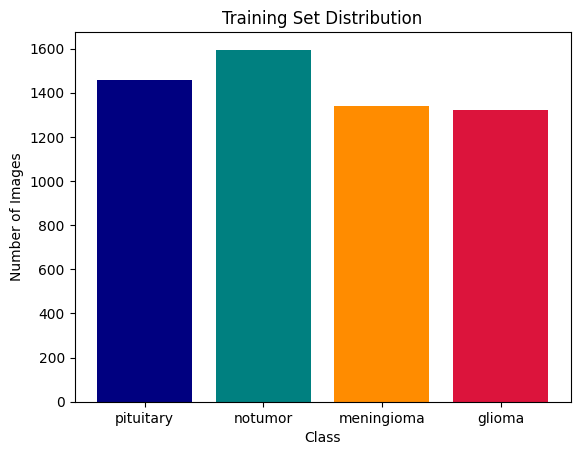

In [ ]:
plot_class_distribution(train)

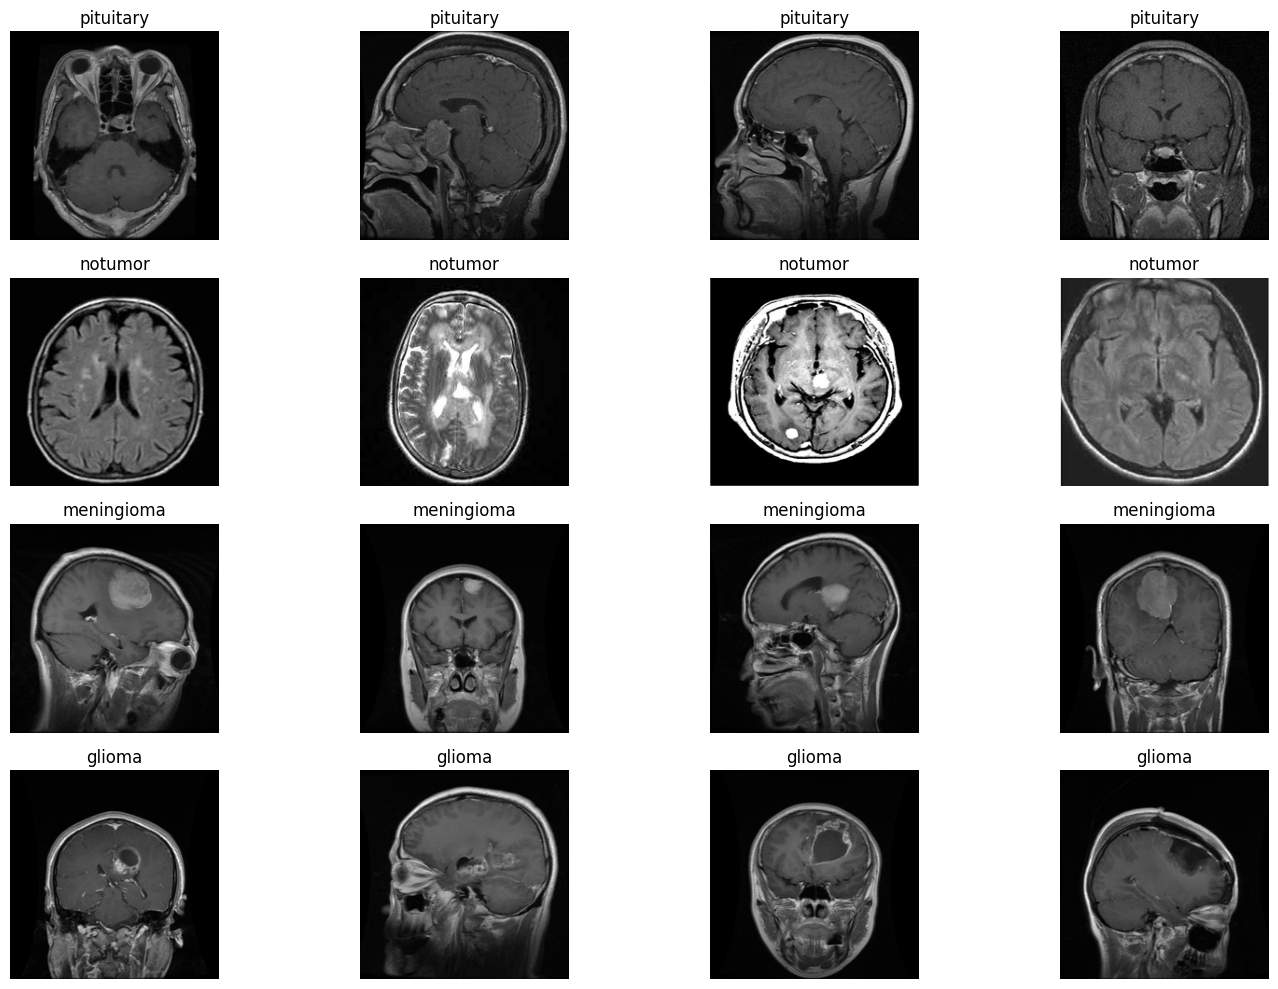

In [ ]:

display_images(train)

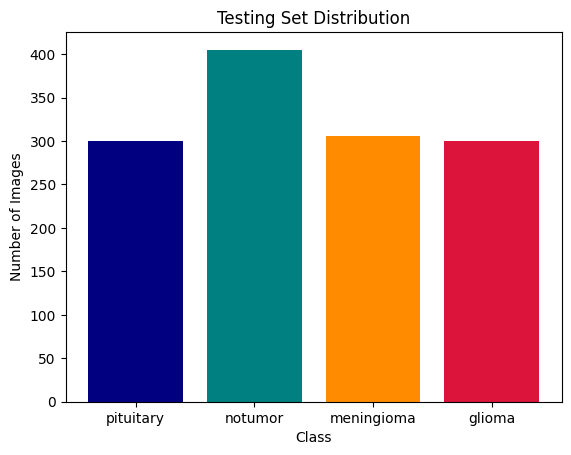

In [ ]:
plot_class_distribution(test)

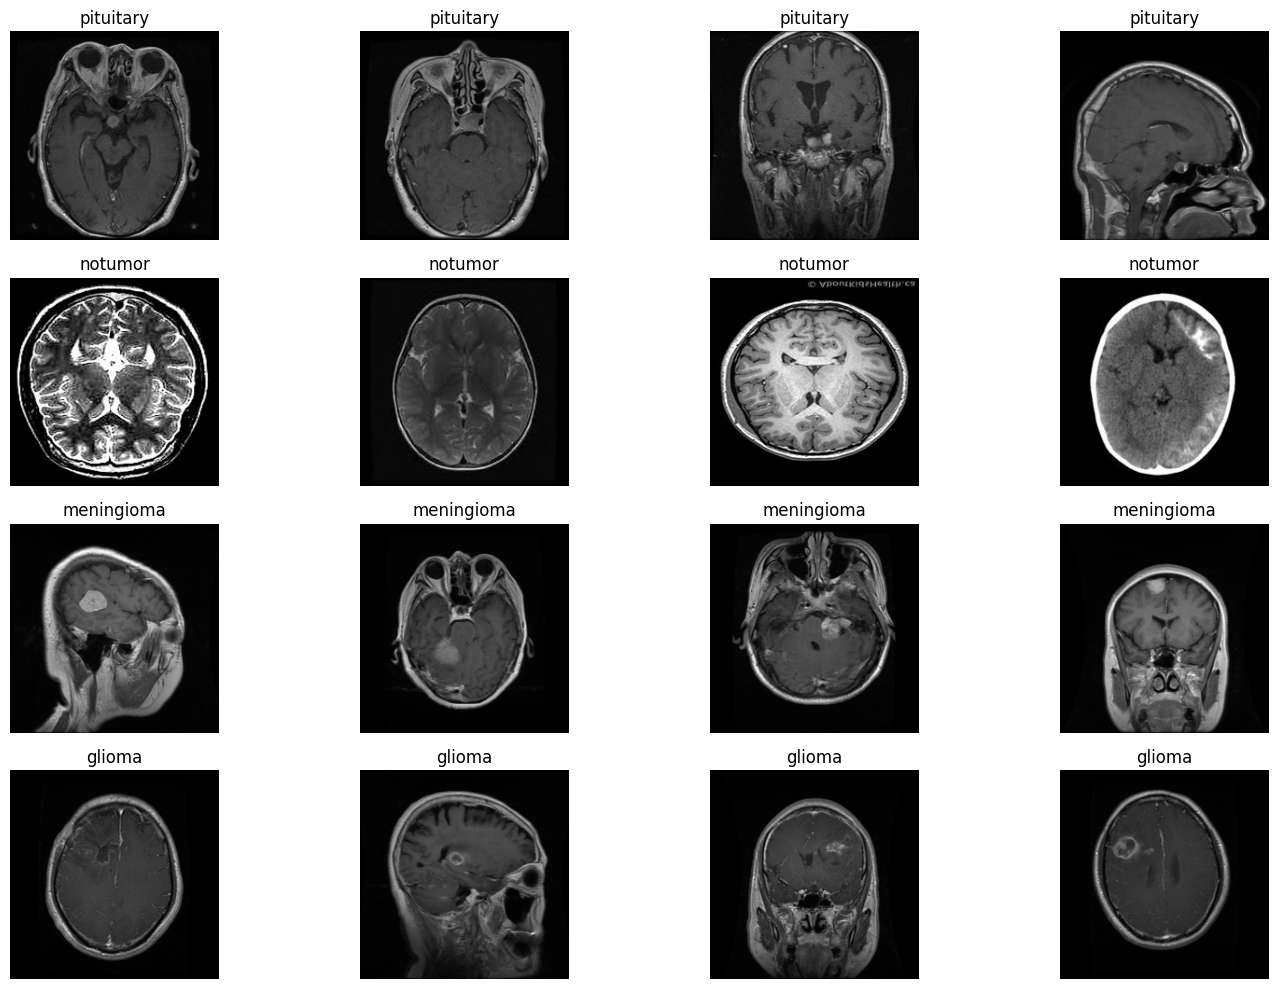

In [ ]:
display_images(test)

In [ ]:
def create_dataset(path):
    my_list = []
    for category in categories:
        category_path = os.path.join(path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            # Ensure we're only adding image files
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])

In [ ]:
train_df = create_dataset(base_directory+'/'+train)
test_df = create_dataset(base_directory+'/'+test)

In [ ]:
train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
train_transform = transforms.Compose([

   transforms.Resize(target_size),
   transforms.RandomHorizontalFlip(),
   transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
   transforms.ColorJitter(brightness=(0.8, 1.2)),
   transforms.RandomRotation(10),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
test_df_split, val_df_split = train_test_split(test_df, test_size=0.5, random_state=random_state)
# Reset indices for consistency
test_df_split = test_df_split.reset_index(drop=True)
val_df_split = val_df_split.reset_index(drop=True)

In [ ]:
train_dataset = ImageDataset(train_df, transform=train_transform)
val_dataset = ImageDataset(val_df_split, transform=test_transform)
test_dataset = ImageDataset(test_df_split, transform=test_transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Conv Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # (B, 32, 224, 224)

        # Conv Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (B, 64, 112, 112)

        # Conv Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (B, 128, 56, 56)

        # Conv Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # (B, 256, 28, 28)

        # Conv Block 5
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # (B, 256, 14, 14)

        # Final shape after pool: (B, 256, 7, 7)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # (B, 32, 112, 112)
        x = self.pool(self.relu(self.conv2(x)))  # (B, 64, 56, 56)
        x = self.pool(self.relu(self.conv3(x)))  # (B, 128, 28, 28)
        x = self.pool(self.relu(self.conv4(x)))  # (B, 256, 14, 14)
        x = self.pool(self.relu(self.conv5(x)))  # (B, 256, 7, 7)

        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [ ]:
model = BrainTumorCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, name='model', patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float("inf")
    tolerance = 0  # Counter for early stopping
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        print("#" * 80)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_brain_tumor_{name}.pth')
            tolerance = 0
        else:
            tolerance += 1
            if tolerance >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    return history

In [ ]:
def test_model(model, test_loader, num_images_to_show=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())  # Store images for visualization

    test_acc = 100 * correct / total

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {test_acc:.2f}%\n")

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=categories))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
print("Starting training...")
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60)

Starting training...
Epoch [1/60]
Train Loss: 1.0425, Train Accuracy: 54.41%
Val Loss: 0.8681, Val Accuracy: 64.02%
################################################################################
Epoch [2/60]
Train Loss: 0.7073, Train Accuracy: 69.99%
Val Loss: 0.7214, Val Accuracy: 68.60%
################################################################################
Epoch [3/60]
Train Loss: 0.5993, Train Accuracy: 75.98%
Val Loss: 0.4893, Val Accuracy: 80.95%
################################################################################
Epoch [4/60]
Train Loss: 0.4838, Train Accuracy: 81.51%
Val Loss: 0.4844, Val Accuracy: 80.49%
################################################################################
Epoch [5/60]
Train Loss: 0.3637, Train Accuracy: 86.80%
Val Loss: 0.4933, Val Accuracy: 81.10%
################################################################################
Epoch [6/60]
Train Loss: 0.3357, Train Accuracy: 87.96%
Val Loss: 0.4059, Val Accuracy: 87.20%
####

In [ ]:
def plot_training_history(history, model_name="model"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

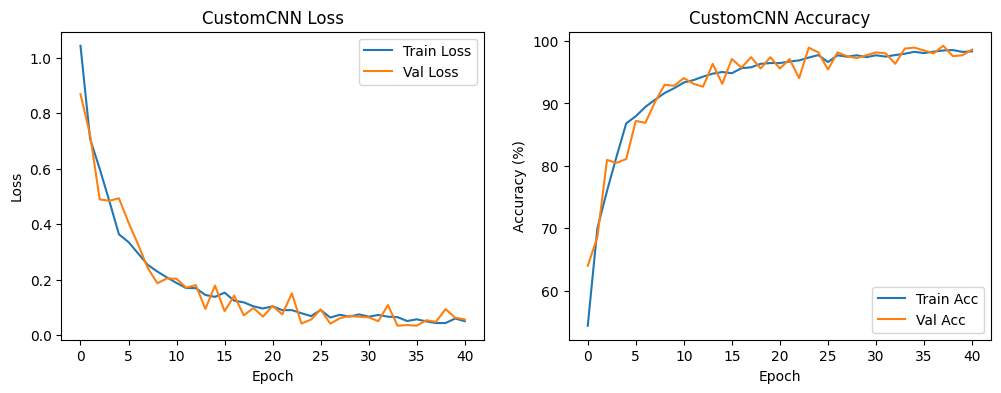

In [ ]:
plot_training_history(history, model_name="CustomCNN")


Loading best model for testing...
Test Accuracy: 98.78%

Classification Report:

              precision    recall  f1-score   support

   pituitary       0.98      1.00      0.99       197
     notumor       1.00      0.97      0.99       151
  meningioma       0.99      0.98      0.98       158
      glioma       0.99      0.99      0.99       149

    accuracy                           0.99       655
   macro avg       0.99      0.99      0.99       655
weighted avg       0.99      0.99      0.99       655



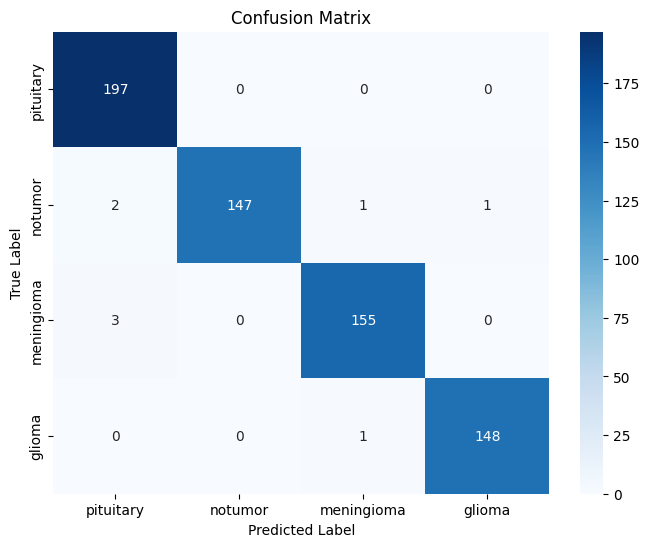

In [ ]:
print("\nLoading best model for testing...")
model.load_state_dict(torch.load('best_brain_tumor_model.pth'))
test_model(model, test_loader)

In [ ]:
def visualize_predictions(model, test_loader, num_images=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct_images, incorrect_images = [], []
    correct_labels, incorrect_labels = [], []
    correct_preds, incorrect_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Separate correct and incorrect predictions
            for i in range(len(predicted)):
                if predicted[i] == labels[i]:
                    correct_images.append(images[i])
                    correct_labels.append(labels[i].cpu().item())
                    correct_preds.append(predicted[i].cpu().item())
                else:
                    incorrect_images.append(images[i])
                    incorrect_labels.append(labels[i].cpu().item())
                    incorrect_preds.append(predicted[i].cpu().item())

    # Visualization
    # Unnormalize using your mean and std
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    num_cols = num_images // 2
    plt.figure(figsize=(15, 7))

    # Display correct predictions
    for i, img_tensor in enumerate(correct_images[:num_images // 2]):
        img_tensor = img_tensor * std + mean  # reverse normalization
        img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
        plt.subplot(2, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"True: {categories[correct_labels[i]]}\nPred: {categories[correct_preds[i]]}", color='green', fontsize=15)
        plt.axis('off')

    # Display incorrect predictions
    for i, img_tensor in enumerate(incorrect_images[:num_images // 2]):
        if i >= len(incorrect_images):
            plt.axis('off')
            continue
        img_tensor = img_tensor * std + mean  # reverse normalization
        img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
        plt.subplot(2, num_cols, num_cols + i + 1)
        plt.imshow(img)
        plt.title(f"True: {categories[incorrect_labels[i]]}\nPred: {categories[incorrect_preds[i]]}", color='red', fontsize=15)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

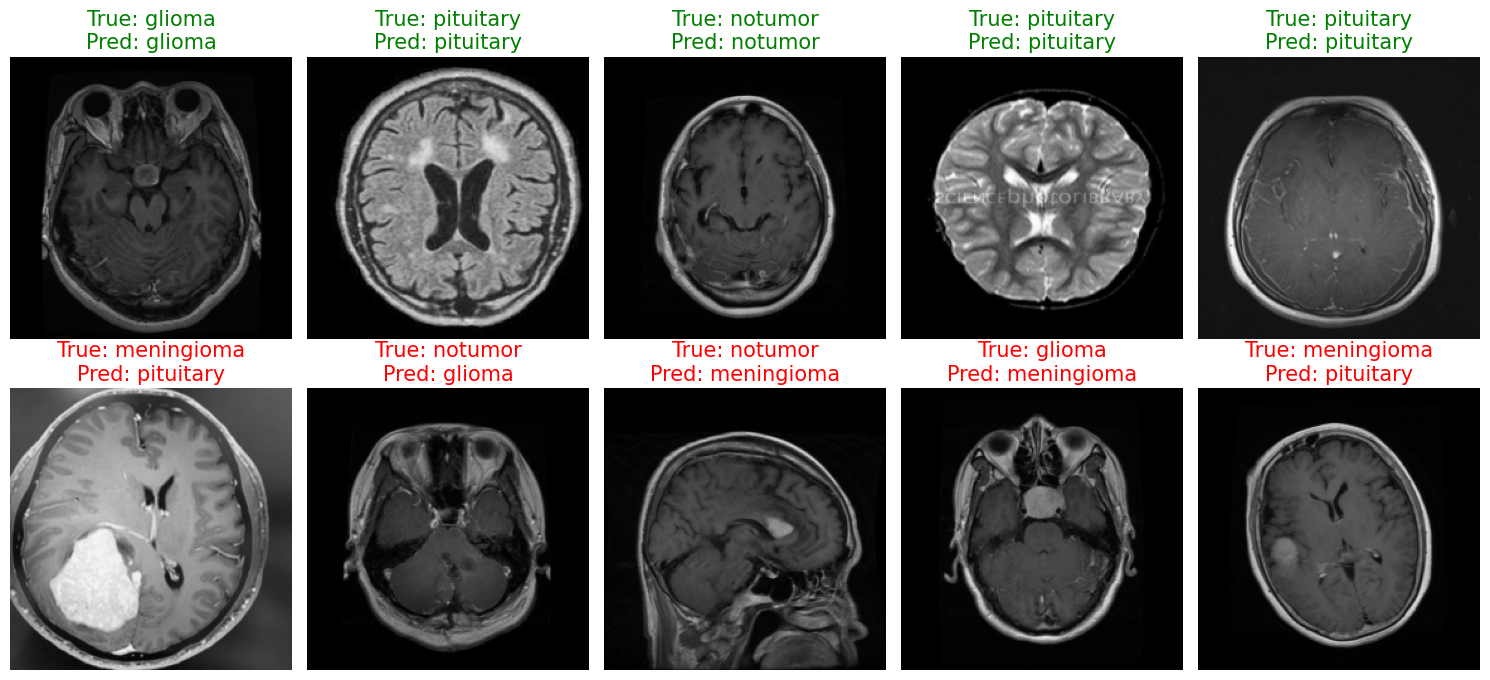

In [ ]:
visualize_predictions(model, test_loader, 10)